In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))

from model import preprocess_data
from model.train import HST
from model.preprocess_data import load_data

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-09-10 15:52:15.654818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:52:16.682991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [3]:
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-09-03 17:04:18.312174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 17:04:18.348009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 17:04:18.348394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
%matplotlib inline

In [8]:
train_dataset = load_data(data_path="/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/df_eth.pkl", batch_size=16)

2024-09-02 11:18:49.985873: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-09-02 11:19:19.986267: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-09-02 11:19:49.990497: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-09-02 11:20:20.007696: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-09-02 11:20:50.017952: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the

In [29]:
import tensorflow as tf
tf.data.experimental.save(
    normalized_dataset, path= "train_dataset_synth_norm"
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282


In [26]:
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/train_dataset_synth"
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282


In [27]:
def compute_mean_and_std(dataset):
    total_sum = tf.zeros((2,),dtype=tf.float64)
    total_sum_sq = tf.zeros((2,),dtype=tf.float64)
    num_samples = 0

    for batch in dataset:
        coords, _ = batch  # Extract only coordinates
        batch_sum = tf.reduce_sum(coords, axis=[0, 1])  # Sum over batch and timesteps
        batch_sum_sq = tf.reduce_sum(tf.square(coords), axis=[0, 1])
        num_samples += coords.shape[0] * coords.shape[1]  # Count total number of timesteps
    
        total_sum += batch_sum
        total_sum_sq += batch_sum_sq

    # Compute mean and standard deviation
    mean = total_sum / num_samples
    variance = (total_sum_sq / num_samples) - tf.square(mean)
    std = tf.sqrt(variance)
    
    return mean, std

# Step 2: Normalize only the coordinates
def normalize_coordinates(coordinates, mean, std):
    return (coordinates - mean) / std

# Step 3: Apply normalization to the first element (coordinates) and leave the second element (skeletal keypoints) unchanged
def normalize_batch(coordinates, mean, std):
    normalized_coordinates = normalize_coordinates(coordinates, mean, std)  # Normalize only coordinates
    return normalized_coordinates  # Return normalized coordinates and unchanged keypoints

# Apply the normalization function to the dataset
def normalize_dataset(dataset):
    mean, std = compute_mean_and_std(dataset)  # Compute mean and std for the coordinates
    print(mean, std)
    return dataset.map(lambda batch1, batch2: (normalize_batch(batch1, mean, std), batch2))  # Normalize dataset

# Example usage:
# Assuming `loaded` is your TensorFlow dataset with tuples (coordinates, skeletal keypoints)
normalized_dataset = normalize_dataset(loaded)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282


tf.Tensor([11.76122154 11.74392565], shape=(2,), dtype=float64) tf.Tensor([5.65538095 5.67038453], shape=(2,), dtype=float64)


In [30]:
len(normalized_dataset)

8000

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282
/tmp/ipykernel_5824/2157719512.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inl

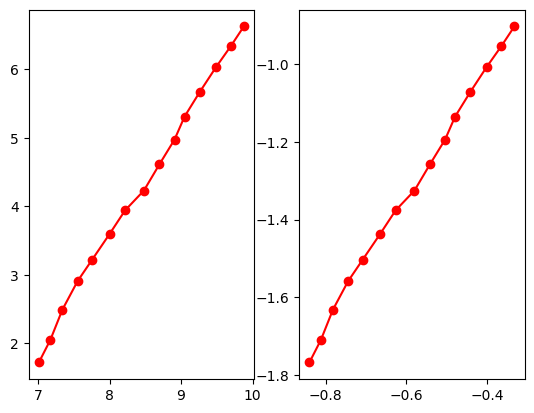

In [28]:
import matplotlib.pyplot as plt
for normalized_batch in normalized_dataset.take(1):
    normalized_coords, _ = normalized_batch

for batch in loaded.take(1):
    coords, _ = batch

idx=2

ground_truth = coords[idx][:,:2].numpy()
prediction = normalized_coords[idx,:,:2].numpy()


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(ground_truth[:,0], ground_truth[:,1], 'ro-')
ax2.plot(prediction[:,0], prediction[:,1], 'ro-')
fig.show()

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 3775467272980396666
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 3775467272980396666
/tmp/ipykernel_5824/787405202.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inli

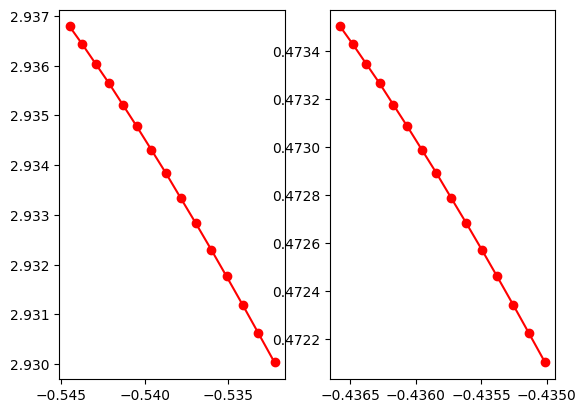

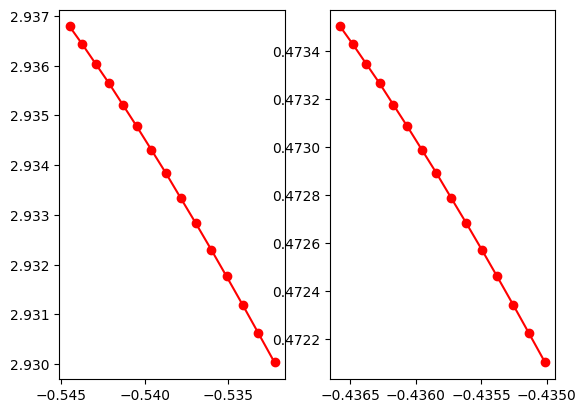

In [18]:
import matplotlib.pyplot as plt
for normalized_batch in normalized_dataset.take(1):
    normalized_coords, _ = normalized_batch

for batch in loaded.take(1):
    coords, _ = batch

idx=0

ground_truth = coords[idx][:,:2].numpy()
prediction = normalized_coords[idx,:,:2].numpy()


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(ground_truth[:,0], ground_truth[:,1], 'ro-')
ax2.plot(prediction[:,0], prediction[:,1], 'ro-')
fig.show()

In [57]:
import datetime
import tensorflow as tf

ckpt_best_dir = "/home/annalena/PedestrianTrajectoryPrediction/trained_models/new_finetuned/ckpts_best/ckpt"

def test_model(checkpoint_dir, test_dataset):
    
    model = HST(15)  # Initialize the model architecture
    optimizer = tf.keras.optimizers.Adam()
    
    # Create a checkpoint object
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    
    # Restore the latest checkpoint
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored checkpoint from {latest_checkpoint}")
    else:
        print("No checkpoint found.")
        return
    
    # Run a forward pass with a batch from the test dataset
    for (batch_x1, batch_x2) in test_dataset.take(1):
        input_batch = (batch_x1, batch_x2)
        output_dict, pred = model(input_batch, training=False)
        #print(output)
        break
    return output_dict, pred, input_batch


In [58]:
output_dict, pred, input = test_model(ckpt_best_dir, loaded)

Restored checkpoint from /home/annalena/PedestrianTrajectoryPrediction/trained_models/new_finetuned/ckpts_best/ckpt/ckpt-4


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16053318953697717525


In [17]:
%matplotlib inline

In [48]:
pred["mixture_logits"]

<tf.Tensor: shape=(32, 1, 5), dtype=float32, numpy=
array([[[-0.02399302,  0.0094029 , -0.01405106,  0.01925307,
          0.01801666]],

       [[-0.02502263,  0.01099973, -0.04514876,  0.01972329,
          0.01546564]],

       [[-0.1053075 , -0.00271288, -0.01009942,  0.0309768 ,
          0.03105577]],

       [[-0.07893602, -0.00090316, -0.02003092,  0.02054777,
          0.01789563]],

       [[-0.03633342,  0.00115314, -0.0022052 ,  0.01364597,
          0.01460355]],

       [[-0.00705806,  0.02352747, -0.0796072 ,  0.02795749,
          0.01545947]],

       [[-0.1586673 , -0.01118607, -0.00639922,  0.03440112,
          0.036771  ]],

       [[-0.04985819,  0.01628714, -0.03180537,  0.02482744,
          0.01644059]],

       [[-0.08864514,  0.00546008, -0.01220817,  0.03280577,
          0.03213584]],

       [[-0.00549487,  0.01867002, -0.08480684,  0.02275934,
          0.00893694]],

       [[-0.12727651, -0.0118534 , -0.00680495,  0.03023347,
          0.03378147]],

  

/tmp/ipykernel_24749/41755945.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


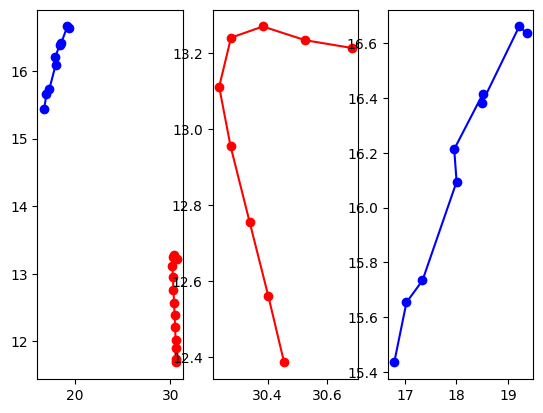

In [66]:
import matplotlib.pyplot as plt 
import numpy as np 

idx = 2

mode =2

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(ground_truth[1:,0], ground_truth[1:,1], 'ro-')
ax1.plot(prediction[6:,0], prediction[6:,1],'bo-')
ax2.plot(ground_truth[6:,0], ground_truth[6:,1], 'ro-')
ax3.plot(prediction[6:,0], prediction[6:,1],'bo-')
fig.show()

In [10]:
prediction

array([[-0.21553525, -0.03838827],
       [-0.16171409,  0.07452854],
       [-0.1618135 ,  0.07464612],
       [-0.16172779,  0.0746796 ],
       [-0.16172747,  0.07479997],
       [-0.16176964,  0.07472967],
       [-0.1637809 ,  0.02403552],
       [-0.16363353,  0.02353285],
       [-0.16364695,  0.02300084],
       [-0.16372512,  0.02258127],
       [-0.16382676,  0.02248896],
       [-0.16380595,  0.02272726],
       [-0.16376704,  0.02319433],
       [-0.16377345,  0.02361044],
       [-0.16379225,  0.02374719]], dtype=float32)

In [11]:
ground_truth

array([[-9.91435010e+01,  8.83475909e+01],
       [-9.63965328e-03,  6.48002861e-02],
       [-9.63965328e-03,  6.48002861e-02],
       [ 1.06159366e-04,  1.12360975e-01],
       [ 6.85870772e-04,  1.13650911e-01],
       [ 1.52057174e-03,  5.51333643e-02],
       [ 1.52057174e-03,  5.51333643e-02],
       [ 3.28008410e-02, -8.91633604e-02],
       [ 3.28008410e-02, -8.91633604e-02],
       [ 6.95928442e-02, -9.87210010e-02],
       [ 6.95928442e-02, -9.87210010e-02],
       [ 6.03811574e-02, -5.19433907e-02],
       [ 4.77498183e-01, -7.33223353e-01],
       [ 4.33753179e-02, -1.53608534e-01],
       [ 1.17056532e-01, -3.05332226e-01]])

In [9]:
idx = 5

mode = 0

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()


new_pos = [ground_truth[0] + i for i in prediction[1:]]
new_pos.insert(0,ground_truth[0])
new_pos = np.asarray(new_pos)


tmp = []
tmp.append(ground_truth[0])
ground_truth_ = np.asarray(ground_truth)
for i in range(1,len(ground_truth_)):
    tmp.append(np.add(np.asarray(tmp[-1]),ground_truth_[i]))

tmp = np.asarray(tmp)

tmp2 = []
for i in range(5):
    tmp2.append(tmp[i])
prediction_ = np.asarray(prediction)
for i in range(6,len(prediction)):
    tmp2.append(np.add(np.asarray(tmp2[-1]),prediction[i]))

tmp2 = np.asarray(tmp2)

plt.plot(tmp2[:,0], tmp2[:,1], 'bo-')
plt.plot(tmp[:,0], tmp[:,1],'ro-')
plt.show()

NameError: name 'np' is not defined

In [14]:
print(prediction)

[[ 0.43505102 -1.1941148 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941144 ]
 [ 0.43505102 -1.1941144 ]
 [ 0.43505102 -1.1941144 ]]


# Plot training loss

In [13]:
import pandas as pd

train_loss_dir = "/home/pbr-student/Downloads/train.csv"
eval_loss_dir = "/home/pbr-student/Downloads/eval.csv"

train_loss = pd.read_csv(train_loss_dir)
eval_loss = pd.read_csv(eval_loss_dir)

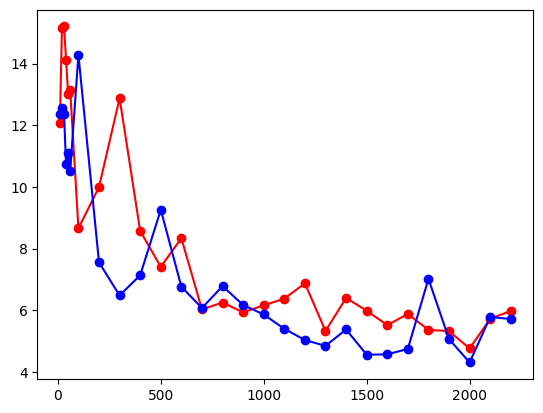

In [16]:
plt.plot(train_loss["Step"], train_loss["Value"], 'ro-')
plt.plot(eval_loss["Step"], eval_loss["Value"], 'bo-')
plt.show()